## Work
1. 試比較有 BN 在 Batch_size = 2, 16, 32, 128, 256 下的差異
2. 請嘗試將 BN 放在 Activation 之前，並比較訓練結果
3. 請於 BN 放在 Input Layer 後，並比較結果

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [19]:
from keras.layers import BatchNormalization, Activation

class Model():
    def __init__(self):
        self.lr = None
        self.batch_size = None
        self.epochs = None
        self.momentum = None
        self.input_shape = None
        self.output_size = None
        self.num_neurons = None
        self.model = None
        self.optimizer = None
        self.UseBN = False
        self.BNBeforeAct = False
        self.BNAftInputLayer = False
        self.dataIsReady = False
        
        return
    
    def setHypPara(self, **HypParam):
        self.lr = HypParam['lr']
        self.epochs = HypParam['epochs']
        self.batch_size = HypParam['batch_size']
        self.momentum = HypParam['momentum']
        self.UseBN = HypParam['UseBN']
        self.BNBeforeAct = HypParam['BNBeforeAct']
        self.BNAftInputLayer = HypParam['BNAftInputLayer']
        
        return
    
    def setModelPara(self, **ModelPara):
        self.input_shape = ModelPara['input_shape']
        self.output_shape = ModelPara['output_shape']
        self.num_neurons = ModelPara['num_neurons']
        
        return
    
    def bulid_mlp(self):       
        input_layer = keras.layers.Input(self.input_shape)
        
        for i, units in enumerate(self.num_neurons):
            if i == 0 and self.BNAftInputLayer is False:
                input_data = input_layer
            elif i == 0 and self.BNAftInputLayer is True:
                input_data = BatchNormalization()(input_layer)
                
            if self.UseBN is True and self.BNBeforeAct is True and i != 0:
                input_data = BatchNormalization()(input_data)
            
            input_data = keras.layers.Dense(units=units,
                                            activation='relu',
                                            name='hidden_layer' + str(i + 1))(input_data)
            
            if self.UseBN is True and self.BNBeforeAct is False:
                input_data = BatchNormalization()(input_data)
        
        out = keras.layers.Dense(units=self.output_shape, activation='softmax', name='output')(input_data)
        
        self.model = keras.models.Model(inputs=[input_layer], outputs=[out])
        self.model.summary()
        
        return
    
    def setModelData(self, **data):
        self.train_input = data['train_input']
        self.train_target = data['train_target']
        self.test_input = data['test_input']
        self.test_target = data['test_target']
        self.dataIsReady = True
    
    def train_model(self):
        # Check parameters
        if self.model is None:
            print("Model is't exist.")
            return
        
        if self.dataIsReady is False:
            print("Data is't exits.")
            return
        
        self.optimizer = keras.optimizers.SGD(lr=self.lr, momentum=self.momentum, nesterov=True)
        self.model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=self.optimizer)
        self.model.fit(self.train_input, self.train_target, 
                       epochs=self.epochs,
                       batch_size=self.batch_size, 
                       validation_data=(self.test_input, self.test_target), 
                       verbose = False,
                       shuffle=True)
        
        # Collect results
        train_loss = self.model.history.history["loss"]
        valid_loss = self.model.history.history["val_loss"]
        train_acc = self.model.history.history["acc"]
        valid_acc = self.model.history.history["val_acc"]
    
        exp_name_tag = "exp-batch_size-%d" % (self.batch_size)
        results[exp_name_tag] = {'train-loss': train_loss,
                                 'valid-loss': valid_loss,
                                 'train-acc': train_acc,
                                 'valid-acc': valid_acc
                                }
        
        return results

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')

def plotResults(results):
    plt.figure(figsize=(10, 10))
    for i, cond in enumerate(results):
        plt.plot(range(len(results[cond]['train-loss'])), results[cond]['train-loss'], label=cond + '-train')
        plt.plot(range(len(results[cond]['valid-loss'])), results[cond]['valid-loss'], label=cond + '-valid')
    plt.title('Loss')
    plt.legend()
    
    plt.figure(figsize=(10, 10))
    for i, cond in enumerate(results):
        plt.plot(range(len(results[cond]['train-acc'])), results[cond]['train-acc'], label=cond + '-train')
        plt.plot(range(len(results[cond]['valid-acc'])), results[cond]['valid-acc'], label=cond + '-valid')
    plt.title('Accuracy')
    plt.legend()

In [20]:
model = Model()

In [21]:
## 超參數設定
model_HypPara = {
    'lr': 0.001,
    'epochs': 50,
    'momentum': 0.95,
    'batch_size': None,
    'UseBN': True,
    'BNBeforeAct': False,
    'BNAftInputLayer': False
}

model_Para = {
    'input_shape': x_train.shape[1:],
    'output_shape': 10,
    'num_neurons': [512, 256, 128], 
}

Batch_Size_List = [256, 128, 32, 16, 2]

data = {'train_input': x_train, 'train_target': y_train, 'test_input': x_test, 'test_target': y_test}

In [15]:
results = {}
for batch_size in Batch_Size_List:
    # Setting Batch Size
    model_HypPara['batch_size'] = batch_size
    
    model.setHypPara(**model_HypPara)
    model.setModelPara(**model_Para)
    
    model.bulid_mlp()
    model.setModelData(**data)
    results.update(model.train_model())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_7 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_8 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_9 (Batch (None, 128)               512       
__________

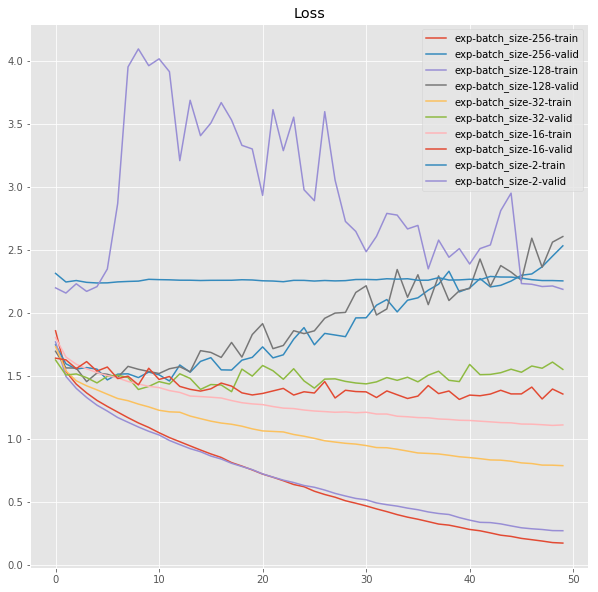

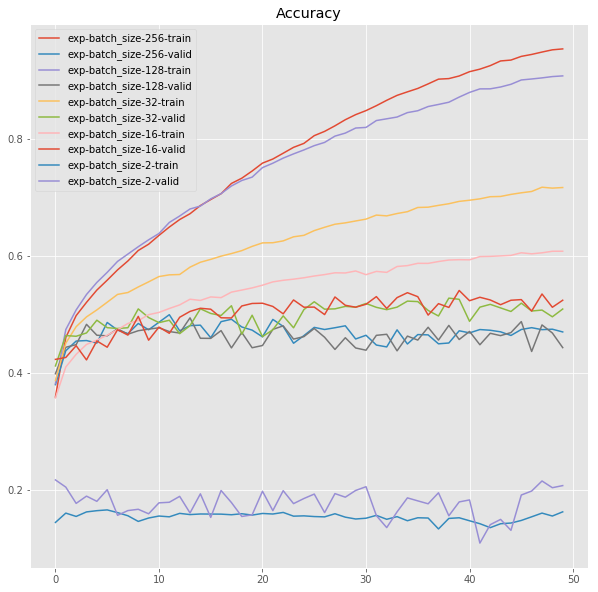

In [30]:
plotResults(results)

# Conclusion
* 從上面的結果可以看出，當 batch size 使用較大的數值可以得到較好的準確率。

In [22]:
model = Model()

## 超參數設定
model_HypPara['BNBeforeAct'] = True

# Setting Batch Size    
model_HypPara['batch_size'] = 256

In [37]:
results = {}
model.setHypPara(**model_HypPara)
model.setModelPara(**model_Para)
    
model.bulid_mlp()
model.setModelData(**data)
results = model.train_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
batch_normalization_28 (Batc (None, 3072)              12288     
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_29 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_30 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
__________

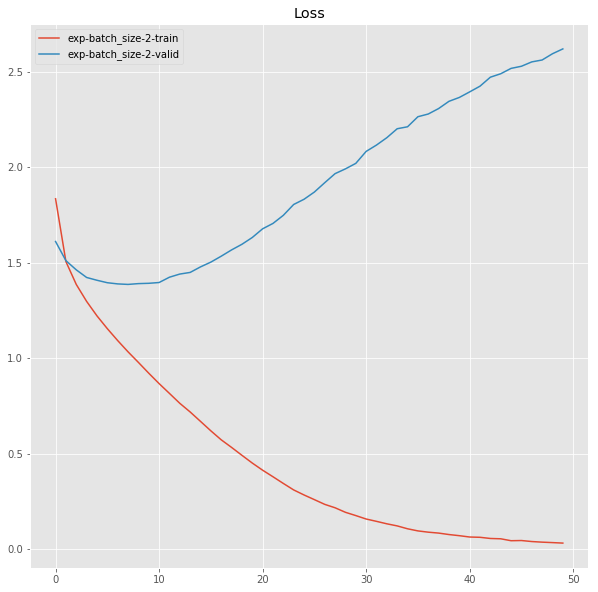

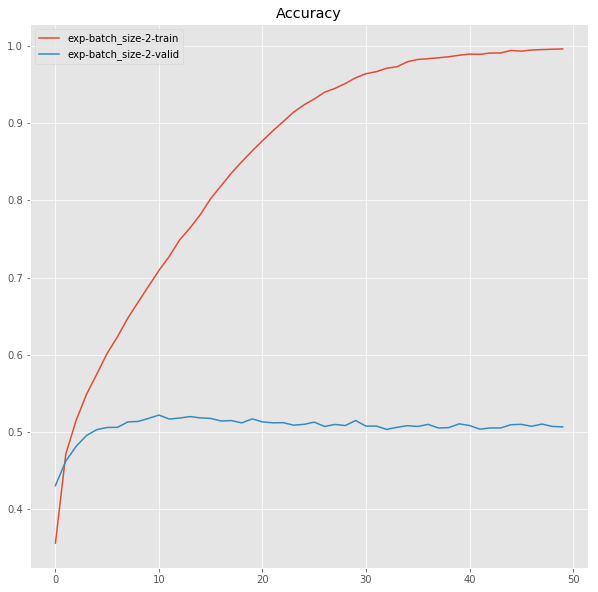

In [38]:
plotResults(results)

# Conclusing
* 從第一個測試跟與第二個測試中可以發現，將 BN 放在 Activation 之前，優化了 model，不論是在 Loss 或者 accuracy 都有更好的表現。

In [23]:
model = Model()

## 超參數設定
model_HypPara['BNBeforeAct'] = False
model_HypPara['BNAftInputLayer'] = True

In [24]:
results = {}
model.setHypPara(**model_HypPara)
model.setModelPara(**model_Para)
    
model.bulid_mlp()
model.setModelData(**data)
results = model.train_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 3072)              12288     
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_10 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_11 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
__________

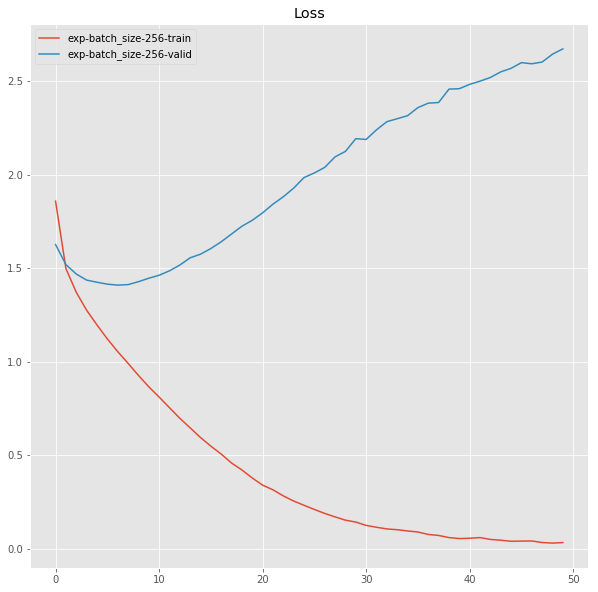

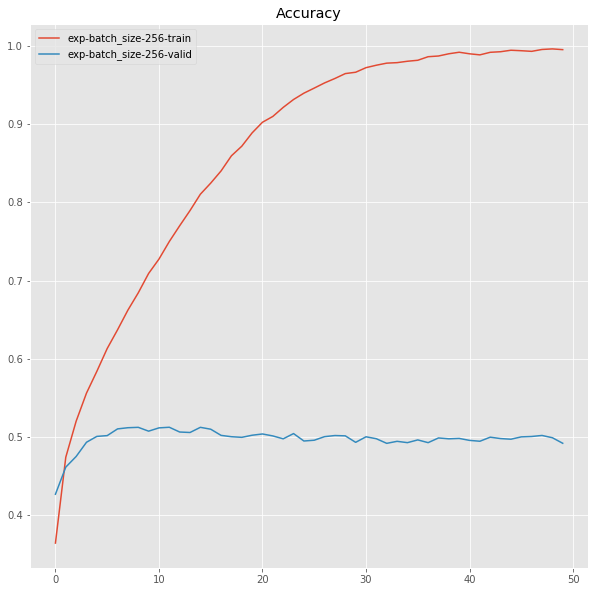

In [25]:
plotResults(results)

# Conclusing
* 與第一個測試跟及第二個測試相比可以發現，將 BN 放在 Input Layer 後，優化了 model，不論是在 Loss 或者 accuracy 都有更好的表現。
* 也就是在三個試驗中，將 BN 放在 Input Layer 後，可以得到最好的準確度。